In [1]:
### conflits with Deepnote ###

# matplotlib inline plotting
%matplotlib inline
# make inline plotting higher resolution
%config InlineBackend.figure_format = 'svg'

### conflits with Deepnote ###

In [2]:
# imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta
import calendar
import re

plt.style.use('dark_background')

In [3]:
# data for Problem 1)
df = pd.read_excel('Data.xlsx', sheet_name='cape', engine='openpyxl')

df = df.rename(columns={df.columns[0]: 'date'})
df = df[df.columns[:4]] # drop any cols above first 4
df['date'] = pd.to_datetime(df['date'], format=('%Y%m'))

df.head()

,date,ret,rf,cape
0,1926-07-01,0.0318,0.0022,11.869694
1,1926-08-01,0.0289,0.0025,12.488808
2,1926-09-01,0.0059,0.0023,12.692615
3,1926-10-01,-0.0292,0.0032,12.426518
4,1926-11-01,0.0284,0.0031,12.615251


In [4]:
# data for Problem 2)
df2 = pd.read_excel('Data.xlsx', sheet_name='cay', engine='openpyxl')

def parse_quater(x):
    x = str(x)
    
    year = x[:4]
    q = x[4]
    
    if q == '1':
        return f'{year}-03-31'
    elif q == '2':
        return f'{year}-06-30'
    elif q == '3':
        return f'{year}-09-30'
    else:
        return f'{year}-12-31'


df2 = df2.rename(columns={df2.columns[0]: 'date'})
df2 = df2[df2.columns[:5]] # drop any cols above first 4
df2 = df2.dropna(how='all')
df2['date'] = df2['date'].apply(parse_quater)
df2['date'] = pd.to_datetime(df2['date'], format=('%Y-%m-%d'))


df2.head()

,date,log excess return,cay,ret,rf
0,1952-12-31,0.092468,0.602544,0.102295,0.004939
1,1953-03-31,-0.041697,0.607042,-0.035683,0.005376
2,1953-06-30,-0.038692,0.602768,-0.032102,0.006082
3,1953-09-30,-0.029554,0.603446,-0.022973,0.006333
4,1953-12-31,0.070750,0.604790,0.077865,0.004241


## Problem 1, a)

The purpose of this problem is to analyze the predictive ability of the Cyclically Adjusted Price-Earnings (CAPE) ratio for future stock returns. The CAPE ratio is also known as the price-smoothed-earnings ratio or as the Shiller P/E ratio and the variable is available for free download at Robert Shillerís website. The CAPE ratio is defined as the real stock price divided by average real earnings over a ten-year period. It has been used in a series of articles by John Campbell and Robert Shiller to examine long-horizon stock market predictability.

Estimate long-horizon predictive regressions:

$$r_{t \rightarrow t+k}=\alpha_{k}+\beta_{k} x_{t}+\varepsilon_{t \rightarrow t+k}$$

where $r_{t \rightarrow t+k}$ is the log excess return on the US stock market from time $t$ to $t+k$ and $x_{t}$ is
the log CAPE ratio at time $t .^{1}$ Consider horizons in the range from one month up to ten years:
$k=1,6,12,24,36,48,60,72,84,96,108,$ and $120 .$ Report and compare the $\beta_{k}$ coefficients and
$R^{2}$ statistics across the forecast horizons. All necessary data to estimate (1) are available in the
excel file "Data.xlsx". The sample period is from 1926:m7 to 2020:m7.

In [5]:
k = [1, 6, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120]

# reverse sorting the data
df = df.set_index('date')
df = df.sort_index(ascending=False)
df

,ret,rf,cape
date,,,
2020-07-01,0.0578,0.0001,29.610927
2020-06-01,0.0246,0.0001,28.843644
2020-05-01,0.0559,0.0001,27.329646
2020-04-01,0.1365,0.0000,25.927359
2020-03-01,-0.1327,0.0012,24.817169
...,...,...,...
1926-10-01,-0.0292,0.0032,12.426518
1926-09-01,0.0059,0.0023,12.692615
1926-08-01,0.0289,0.0025,12.488808


#### Log k-period returns

The $k$ -period log return is calculated as
$$
\begin{aligned}
r_{t \rightarrow t+k} &=\log \left(1+R_{t \rightarrow t+k}\right) \\
&=\log \left(1+R_{t+1}\right)+\log \left(1+R_{t+2}\right)+\ldots+\log \left(1+R_{t+k}\right) \\
&=r_{t+1}+r_{t+2}+\ldots+r_{t+k}
\end{aligned}
$$

In [6]:
# log-transforming CAPE
df['cape'] = np.log(df['cape'])

# generating k-period excess log-returns for 
df['ret'] = np.log(1 + df['ret'])
df['rf'] = np.log(1 + df['rf'])

for period in k:
    df[f'k={period}'] = df['ret'].rolling(period).sum() - df['rf'].rolling(period).sum()
    
# resording again
df = df.sort_index(ascending=True)

#### Lagging

We always lag the predictive variable in predictive regressions. Here we get $r_{t+1}=\alpha+\beta x_{t}+\varepsilon_{t+1}$ _(abstracting from the k-period returns notation)_. Thus we move the returns columns one period backwards.

In [7]:
# Lag all returns one period back-wards
non_lagged_returns = df[df.columns[3:]]  # in case I need dropped values later
df[df.columns[3:]] = df[df.columns[3:]].shift(-1)
df = df.dropna(how='all')
df

,ret,rf,cape,k=1,k=6,k=12,k=24,k=36,k=48,k=60,k=72,k=84,k=96,k=108,k=120
date,,,,,,,,,,,,,,,
1926-07-01,0.031305,0.002198,2.473988,0.025993,0.046851,0.192655,0.372093,0.709978,0.359452,-0.065708,-0.793039,-0.243071,-0.305186,-0.027681,0.339625
1926-08-01,0.028490,0.002497,2.524833,0.003585,0.061703,0.186116,0.410563,0.762309,0.336451,-0.087611,-0.503864,-0.155322,-0.276886,-0.027522,0.323481
1926-09-01,0.005883,0.002297,2.541020,-0.032830,0.059413,0.228937,0.435296,0.702673,0.196794,-0.435396,-0.537282,-0.271492,-0.282774,-0.005150,0.329647
1926-10-01,-0.029635,0.003195,2.519833,0.024909,0.096821,0.217823,0.481284,0.512011,0.137814,-0.325310,-0.645640,-0.325956,-0.266682,0.095612,0.431243
1926-11-01,0.028004,0.003095,2.534906,0.025791,0.124729,0.256510,0.567606,0.351362,0.082074,-0.445239,-0.731136,-0.255846,-0.211587,0.118341,0.438508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-01,-0.142370,0.001199,3.211536,0.127953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-01,0.127953,0.000000,3.255299,0.054293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-01,0.054393,0.000100,3.307972,0.024202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
res = []  # placeholder for results

for period in k:
    data = df[[f'k={period}', 'cape']].dropna(how='any')
    
    Y = data[f'k={period}']
    X = sm.add_constant(data['cape'])

    fit = sm.OLS(endog=Y, exog=X).fit()
    
    res.append({
        'horizon': period,
        'alpha': fit.params['const'],
        'beta': fit.params['cape'],
        'R2': fit.rsquared_adj * 100
    })

res = pd.DataFrame(res)
res

,horizon,alpha,beta,R2
0,1,0.032864,-0.009782,0.454831
1,6,0.205182,-0.061759,3.193525
2,12,0.446518,-0.136438,7.186357
3,24,0.863311,-0.263625,13.235476
4,36,1.171717,-0.353641,16.864028
5,48,1.410224,-0.419058,18.923008
6,60,1.585868,-0.460648,19.757823
7,72,1.695399,-0.475547,20.920020
8,84,1.878679,-0.516682,23.922550
9,96,2.127895,-0.583363,27.275441


#### Conclusion

As we see from the table above. The predictive power of CAPE increases when looking at longer return-horizons.

## Problem 1, b)

The use of overlapping data in (1) leads to autocorrelation in the error term. To address
this issue, we can use e.g. the Newey-West estimator to compute $t$ -statistics across the different
forecast horizons. To examine the effect of how standard errors are computed in long-horizon
regressions, try with two different lag-length specifications in the Newey-West estimator. First,
try to set the lag length in the Newey-West estimator equal to the forecast horizon and then
afterwards try with no lags in the Newey-West estimator.

In [9]:
res = []  # placeholder for results

for period in k:
    data = df[[f'k={period}', 'cape']].dropna(how='any')
    
    Y = data[f'k={period}']
    X = sm.add_constant(data['cape'])

    fit_nw_0 = sm.OLS(endog=Y, exog=X).fit(cov_type='HAC', cov_kwds={'maxlags': 0})
    fit_nw_k = sm.OLS(endog=Y, exog=X).fit(cov_type='HAC', cov_kwds={'maxlags': period})
    
    res.append({
        'horizon': period,
        'T-stat: NW (0 lags)': fit_nw_0.tvalues['cape'],
        'T-stat: NW (k lags)': fit_nw_k.tvalues['cape']
    })

res = pd.DataFrame(res)
res

,horizon,T-stat: NW (0 lags),T-stat: NW (k lags)
0,1,-2.028352,-1.831084
1,6,-5.952230,-3.040038
2,12,-9.257427,-3.423782
3,24,-12.989475,-3.283021
4,36,-13.784869,-3.066353
5,48,-16.111079,-3.209365
6,60,-18.894856,-3.537802
7,72,-20.524614,-3.580867
8,84,-22.790482,-3.486762
9,96,-23.624109,-3.462548


#### Conclusion

- When we don't lag our Newey-West std. errors we don't take into account serial correlation.
- Thus we get large (absolute) t-statistics when using 0-lags, however this has low power due to serial correlation. 
- $H_0:\; \beta_k=0$ can however be rejected as $k$ increases for the model with $k$ lags.
- The reason why $k$ lags is a relevant choice is that the overlap in returns implies that $\varepsilon_{t+k} \sim M A(k-1)$ by construction.

## Problem 1, c)

Similar to the price-dividend ratio, the CAPE ratio is highly persistent and slow to mean-
revert, implying that forecasts build up over time. Make two scatter plots where you plot the
time $t$ log CAPE ratio against the one-month ahead log excess return $\left(r_{t \rightarrow t+1}\right)$ and the ten-year
ahead log excess return $\left(r_{t \rightarrow t+120}\right),$ respectively.

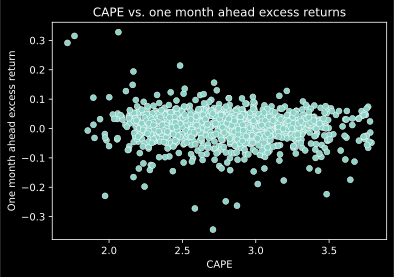

In [10]:
sns.scatterplot(x='cape', y='k=1', data=df)

plt.ylabel('One month ahead excess return')
plt.xlabel('CAPE')

plt.title('CAPE vs. one month ahead excess returns')
plt.show()

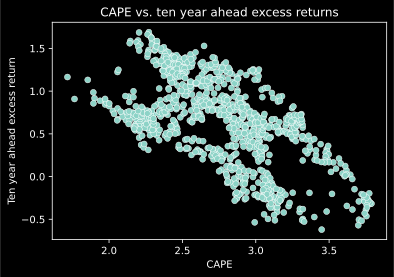

In [11]:
sns.scatterplot(x='cape', y='k=120', data=df)

plt.ylabel('Ten year ahead excess return')
plt.xlabel('CAPE')

plt.title('CAPE vs. ten year ahead excess returns')

plt.show()

#### Conclusion
The predictive power of CAPE becomes more visible at very long horizons as CAPE is slow to mean revert - this is the same result as we saw ealier.

## Problem 1, d)

In-sample evidence of time-varying expected excess returns does not imply that it is possible
to predict returns out-of-sample. Use an out-of-sample period from 1990:m1 to 2020:m7 to check
the out-of-sample predictive power of the log CAPE ratio by computing the out-of-sample $R^{2}$
and Clark and West test statistic for the $k=1,6,$ and 12 horizons. In addition, plot the Goyal
and Welch (2008) cumulative-squared-error-difference figure for $k=1$.

In [12]:
# information from problem
start_oos = datetime(1990, 1, 1)
horizons = [1, 6, 12]
nlag = 1  # Lag x relative to y as specified in the forecast regression.

oos_cols = [f'k={period}' for period in horizons]
oos_cols.append('cape')

# select relevant data
oos_data = df[oos_cols]

oos_data.head()

,k=1,k=6,k=12,cape
date,,,,
1926-07-01,0.025993,0.046851,0.192655,2.473988
1926-08-01,0.003585,0.061703,0.186116,2.524833
1926-09-01,-0.032830,0.059413,0.228937,2.541020
1926-10-01,0.024909,0.096821,0.217823,2.519833
1926-11-01,0.025791,0.124729,0.256510,2.534906


In [13]:
# prevailing mean benchmark forecast - using expanding window
PM = []
PM_data = non_lagged_returns[[f'k={i}' for i in horizons]]


for window in PM_data.expanding(1):  # this works
    
    if window.index[-1] >= start_oos:
        res = {'date': window.index[-1]}
        
        for col in window.columns:

            k = re.findall(string=col, pattern='[^\d](\d+)$')[0]
            k = int(k)
            
            window_data = window[f'k={k}'].iloc[0:-k]
            
            res.update({f'PM_k={k}': np.mean(window_data)})

        # save resulting dictionary
        PM.append(res)
        
PM_result = pd.DataFrame(PM).set_index('date', drop=True)
PM_result

,PM_k=1,PM_k=6,PM_k=12
date,,,
1990-01-01,0.004984,0.029831,0.058755
1990-02-01,0.004871,0.029673,0.058721
1990-03-01,0.004879,0.029511,0.058732
1990-04-01,0.004896,0.029383,0.058746
1990-05-01,0.004846,0.029259,0.058659
...,...,...,...
2020-03-01,0.005148,0.031051,0.061706
2020-04-01,0.005015,0.030894,0.061552
2020-05-01,0.005125,0.030835,0.061478


In [14]:
# Predictive regression forecast - also using expanding window
PR = []


for window in oos_data.expanding(1):  # this works
    
    if window.index[-1] >= start_oos:
        res = {'date': window.index[-1]}
        
        for col in window.columns:
            
            if col != 'cape':
                k = re.findall(string=col, pattern='[^\d](\d+)$')[0]
                k = int(k)
                
                Y = window[f'k={k}'].iloc[0:-(k + nlag)]
                X = sm.add_constant(window['cape']).iloc[0:-(k + nlag)]

                # fit OOS predictive regression
                fit = sm.OLS(endog=Y, exog=X).fit(cov_type='HAC', cov_kwds={'maxlags': k})
                
                pr_val = np.dot(np.matrix([1, window['cape'].iloc[-(1 + nlag)]]), fit.params.values)
                res.update({f'PR_k={k}': pr_val[0, 0]})

        # save resulting dictionary
        PR.append(res)

        
PR_result = pd.DataFrame(PR).set_index('date', drop=True)
PR_result

,PR_k=1,PR_k=6,PR_k=12
date,,,
1990-01-01,0.000064,-0.000205,-0.007794
1990-02-01,0.000630,0.004022,0.001917
1990-03-01,0.001328,0.007952,0.011008
1990-04-01,0.000945,0.005334,0.005592
1990-05-01,0.000908,0.005363,0.005870
...,...,...,...
2020-03-01,-0.000835,-0.005909,-0.021442
2020-04-01,0.000979,0.006888,0.007664
2020-05-01,0.000752,0.004115,0.001645


In [15]:
oos_data = non_lagged_returns.join(PR_result)
oos_data = oos_data.join(PM_result)
oos_data

,k=1,k=6,k=12,k=24,k=36,k=48,k=60,k=72,k=84,k=96,k=108,k=120,PR_k=1,PR_k=6,PR_k=12,PM_k=1,PM_k=6,PM_k=12
date,,,,,,,,,,,,,,,,,,
1926-07-01,0.029107,0.076557,0.151879,0.395039,0.695591,0.348264,0.031850,-1.055330,-0.112727,-0.160007,-0.070980,0.304169,NaN,NaN,NaN,NaN,NaN,NaN
1926-08-01,0.025993,0.046851,0.192655,0.372093,0.709978,0.359452,-0.065708,-0.793039,-0.243071,-0.305186,-0.027681,0.339625,NaN,NaN,NaN,NaN,NaN,NaN
1926-09-01,0.003585,0.061703,0.186116,0.410563,0.762309,0.336451,-0.087611,-0.503864,-0.155322,-0.276886,-0.027522,0.323481,NaN,NaN,NaN,NaN,NaN,NaN
1926-10-01,-0.032830,0.059413,0.228937,0.435296,0.702673,0.196794,-0.435396,-0.537282,-0.271492,-0.282774,-0.005150,0.329647,NaN,NaN,NaN,NaN,NaN,NaN
1926-11-01,0.024909,0.096821,0.217823,0.481284,0.512011,0.137814,-0.325310,-0.645640,-0.325956,-0.266682,0.095612,0.431243,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-01,0.127953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000979,0.006888,0.007664,0.005015,0.030894,0.061552
2020-05-01,0.054293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000752,0.004115,0.001645,0.005125,0.030835,0.061478
2020-06-01,0.024202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000327,0.000823,-0.005306,0.005168,0.030789,0.061517


#### Calculations
Calculating $R^2$ as defined as,

$$R_{O O S}^{2}=1-\frac{\sum_{i=t+h+1}^{T}\left(r_{i}-\widehat{r}_{i}\right)^{2}}{\sum_{i=t+h+1}^{T}\left(r_{i}-\bar{r}_{i}\right)^{2}}$$

where $\hat{r}$ is the predictive regression forecast, and $\bar{r}$ is the prevailing mean forecast.

Afterwards we wish to test $H_{0}: R_{O O S}^{2} \leq 0$ _(no predictability)_ using the Clark and West test. First we compute

$$f_{i}=\left(r_{i}-\bar{r}_{i}\right)^{2}-\left(r_{i}-\widehat{r}_{i}\right)^{2}+\left(\bar{r}_{i}-\widehat{r}_{i}\right)^{2}$$

and run the regression 

$$f_{i}=\theta+u_{i}, \quad i=1, \ldots, T-t-h$$

If we use autocorrelation robust std. errors (Newey West) we can perform a standard t-test on $\hat{\theta}$ for inference.

In [16]:
MSE = []

for period in horizons:
    # Predictive regression error
    oos_data[f'e_PR_k={period}'] = oos_data[f'k={period}'] - oos_data[f'PR_k={period}']
    # Predictive mean error
    oos_data[f'e_PM_k={period}'] = oos_data[f'k={period}'] - oos_data[f'PM_k={period}']  
    
    MSE_PR = np.mean(np.power(oos_data[f'e_PR_k={period}'], 2))
    MSE_PM = np.mean(np.power(oos_data[f'e_PM_k={period}'], 2))
    
    R2OOS = 100 * (1 - (MSE_PR/MSE_PM))
    
    # calculating Clark-West test
    f = np.power(oos_data[f'e_PM_k={period}'], 2) - np.power(oos_data[f'e_PR_k={period}'], 2) + np.power((oos_data[f'PM_k={period}'] - oos_data[f'PR_k={period}']), 2)
    
    Y = f.dropna()
    X = np.ones(shape=(Y.shape[0], 1))    

    fit = sm.OLS(endog=Y, exog=X).fit(cov_type='HAC', cov_kwds={'maxlags': period})
    
    # data for plotting  the Goyal and Welch (2008) cumulative-squared-error-difference figure for k = 1.
    if period == 1:
        oos_data['GW'] = np.power(oos_data[f'e_PM_k={period}'], 2).cumsum() - np.power(oos_data[f'e_PR_k={period}'], 2).cumsum()
    
    MSE.append({
        'Horizon': period,
        'R2': R2OOS,
        'P-value': fit.pvalues[0] / 2  # remember - we are testing one-sided (Normal CDF is symmetric)
    })
    
pd.DataFrame(MSE)

,Horizon,R2,P-value
0,1,-2.501215,0.472038
1,6,-14.842058,0.432010
2,12,-37.708539,0.444608


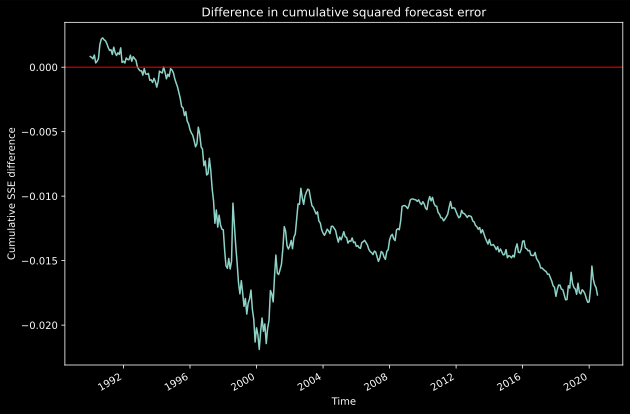

In [17]:
oos_data['GW'].plot(figsize=(10, 7))

plt.axhline(0, color='red', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Cumulative SSE difference')

plt.title('Difference in cumulative squared forecast error')

plt.show()

#### Conclusion
As expected we see that out-of-sample evidence shows that CAPE is not able to predict returns _(at least not out-of-sample)_. The out-of-sample $R^2$ is negative and the Clark and West test is not able to reject the $H_0$ of no predictability. As we also see from the cumulative-squared-error-difference figure, the predictive ablity of CAPE has been unstable over time.

## Problem 2, a)

Lettau and Ludvigson (2001) find that there is a cointegration relationship between consumption $\left(c_{t}\right),$ financial asset wealth $\left(a_{t}\right),$ and income $\left(y_{t}\right)$. They show that the estimated cointegration residual $\widehat{cay}$ has the ability to capture time-varying expected returns on the US stock market. The excel file "TimeVaryingRiskPremia.xlsx" contains the log excess return on the S\&P500 index as well as the original cay data used by Lettau and Ludvigson (2001) with a sample period from 1952:q4 to 1998:q3.

Estimate the predictive regression model:
$$
r_{t \rightarrow t+k}=\alpha_{k}+\beta_{k} \widehat{c a y}_{t}+\varepsilon_{t \rightarrow t+k}
$$
where $r_{t \rightarrow t+k}$ is the $k$ -period ahead log excess return. Is $\beta_{k}$ statistically significant across horizons? Compare your results with Table VI (row 2) in Lettau and Ludvigson (2001). $^{2}$

In [18]:
k = [1, 2, 3, 4, 8, 12, 16, 24]  # forecast horizons

In [19]:
df = df2
df = df.rename(columns={'ret': 'S&P','log excess return': 'ret'})
df = df.set_index('date', drop=True)
df.head()

,ret,cay,S&P,rf
date,,,,
1952-12-31,0.092468,0.602544,0.102295,0.004939
1953-03-31,-0.041697,0.607042,-0.035683,0.005376
1953-06-30,-0.038692,0.602768,-0.032102,0.006082
1953-09-30,-0.029554,0.603446,-0.022973,0.006333
1953-12-31,0.070750,0.604790,0.077865,0.004241


In [20]:
for period in k:
    df[f'k={period}'] = df['ret'].rolling(period).sum()
    df[f'k={period}'] = df[f'k={period}'].dropna().iloc[1:]  # drop first observation - implicit lag
    
df.head(n=10)

,ret,cay,S&P,rf,k=1,k=2,k=3,k=4,k=8,k=12,k=16,k=24
date,,,,,,,,,,,,
1952-12-31,0.092468,0.602544,0.102295,0.004939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953-03-31,-0.041697,0.607042,-0.035683,0.005376,-0.041697,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953-06-30,-0.038692,0.602768,-0.032102,0.006082,-0.038692,-0.080389,NaN,NaN,NaN,NaN,NaN,NaN
1953-09-30,-0.029554,0.603446,-0.022973,0.006333,-0.029554,-0.068247,-0.109943,NaN,NaN,NaN,NaN,NaN
1953-12-31,0.070750,0.604790,0.077865,0.004241,0.070750,0.041196,0.002504,-0.039193,NaN,NaN,NaN,NaN
1954-03-31,0.091315,0.614112,0.099671,0.003703,0.091315,0.162065,0.132511,0.093819,NaN,NaN,NaN,NaN
1954-06-30,0.088655,0.617901,0.095901,0.002926,0.088655,0.179970,0.250720,0.221166,NaN,NaN,NaN,NaN
1954-09-30,0.108374,0.622924,0.116368,0.001708,0.108374,0.197029,0.288344,0.359094,NaN,NaN,NaN,NaN
1954-12-31,0.123406,0.611707,0.134620,0.002896,0.123406,0.231780,0.320435,0.411750,0.372557,NaN,NaN,NaN


In [21]:
res = []

for period in k:
    Y = df[f'k={period}'].dropna().values
    X = df['cay'].iloc[:-period].values
    X = sm.add_constant(X)

    # fit OOS predictive regression
    fit = sm.OLS(endog=Y, exog=X).fit(cov_type='HAC', cov_kwds={'maxlags': period})
    
    res.append({
        'Horizon': period,
        'Beta': fit.params[1],
        't-stat': fit.tvalues[1],
        'R2': fit.rsquared_adj
    })


results = pd.DataFrame(res)
results

,Horizon,Beta,t-stat,R2
0,1,2.154744,3.971369,0.088550
1,2,3.796311,3.739416,0.117052
2,3,5.452758,3.648954,0.158731
3,4,6.751756,3.890468,0.178875
4,8,8.366383,3.662538,0.155721
5,12,8.610317,3.150374,0.138208
6,16,7.872463,2.967739,0.103365
7,24,12.268554,2.800466,0.146477


#### Conclusion

Below is the table in question from the article,

_Table VI (row 2) in Lettau and Ludvigson (2001):_

|k|1|2|3|4|8|12|16|24|
|---|---|---|---|---|---|---|---|---|
|Beta|2.16|3.8|5.43|6.72|8.35|8.57|7.86|12.44|
|t-stat|3.44|3.34|3.37|3.7|3.73|3.24|2.99|3.41|
|R2|0.09|0.12|0.16|0.18|0.16|0.15|0.11|0.16|


We get very similar results as did study did. Thus we're able to _(accounting for these particular results)_ to show that the estimated cointegration residual $\widehat{cay}$ is able to capture time-varying expected returns on the US stock market.

## Problem 2, b)
It is important to take into account small sample bias in order to be able to conduct valid
inference from predictive regressions. Small sample bias in predictive regressions is particularly
severe for financial predictive variables such as the CAPE ratio, the price-dividend ratio and
other predictive variables scaled by price, but often found to be less severe for macroeconomic
predictive variables such as the cay ratio. To judge the degree of small sample bias in the
predictive regression in $r_{t \rightarrow t+k}=\alpha_{k}+\beta_{k} \widehat{c a y}_{t}+\varepsilon_{t \rightarrow t+k}$ conduct a bootstrap analysis where you bootstrap under the null
hypothesis of no predictability and assume an $\mathrm{AR}(1)$ data-generating process for $\widehat{c a y}$:

$$
\begin{aligned}
r_{t+1} &=\alpha+\varepsilon_{t+1} \\
\widehat{c a y}_{t+1} &=\mu+\phi \widehat{c a y}_{t}+\eta_{t+1}
\end{aligned}
$$

Compute $N=10,000$ artificial estimates of the slope coefficients under the null of no predictability and then compute the degree of bias in $\beta_{k}$ as well as one-sided empirical $p$-values across the different forecast horizons. In addition, make a histogram of the bootstrapped slope coefficients for $k=1 .$ Based on the output from your bootstrap analysis, do the predictive regression in (2) suffer from small sample bias?

#### Solution

Using residual-based bootstrapping. We're bootstrapping under the null of no predictability. We are told to assume and $AR(1)$ process for the predictive variable (cay)

- Thus we first estimate the two following equations,

$$
\begin{align}
(1):&\qquad r_{t+1} =\alpha+\varepsilon_{t+1} \\
(2):&\qquad pd_{t+1} =\mu+\phi p d_{t}+\eta_{t+1}
\end{align}
$$

- Then save the residuals and coefficients _(we save the residuals in pairs to preserve the cross-correlation of the residuals)_.
- We construct $N$ bootstrap samples of length $T$ by setting the initial values of $r_{t}$ and $p d_{t}$ equal to their sample averages and by randomly selecting residual pairs (with replacement) from (1) and (2).
- We then estimate $\beta$ from each bootstrap sample:
$$
r_{t+1}=\alpha+\beta p d_{t}+\varepsilon_{t+1}
$$
which will provide us with $N$ artificial estimates of the slope coefficient:
$\widetilde{\beta}^{(1)}, \widetilde{\beta}^{(2)}, \ldots, \widetilde{\beta}^{(N)}$

- The size of the bias given by:
$$
\operatorname{bias}(\widehat{\beta})=\frac{1}{N} \sum_{i=1}^{N} \widetilde{\beta}^{(i)}-\beta_{0}
$$
where $\beta_{0}=0$ in our case.
- We can compute the empirical one-sided $p$ -value under the null hypothesis as
$$
P(\widetilde{\beta}<\widehat{\beta})=\frac{1}{N} \sum_{i=1}^{N} I\left[\widetilde{\beta}^{(i)}<\widehat{\beta}\right]
$$

In [22]:
# from assignment
m = 10000

In [23]:
# return regression under H0 - equation (1)
alpha = np.mean(df['ret'].iloc[1:])
e1 = df['ret'].iloc[1:] - alpha

In [24]:
# AR(1) model - equation (2):
Y = df['cay'].shift(-1).dropna()
X = df['cay'].iloc[:-1]
X = sm.add_constant(X)

out_ar1 = sm.OLS(endog=Y, exog=X).fit()

theta = out_ar1.params
e2 = out_ar1.resid

In [25]:
# paramters to use in bootstrap
a = np.matrix([alpha, theta[0]]).T
phi = np.matrix([[0,0], [0, theta[1]]])
e = np.matrix([e1, e2]).T  # important to save residuals in pairs

X = df[['ret', 'cay']]
X = sm.add_constant(X)
X

,const,ret,cay
date,,,
1952-12-31,1.0,0.092468,0.602544
1953-03-31,1.0,-0.041697,0.607042
1953-06-30,1.0,-0.038692,0.602768
1953-09-30,1.0,-0.029554,0.603446
1953-12-31,1.0,0.070750,0.604790
...,...,...,...
1997-09-30,1.0,0.059567,0.585296
1997-12-31,1.0,0.015896,0.575760
1998-03-31,1.0,0.118251,0.574597


In [26]:
T = X.shape[0]

beta_sim = {period: [] for period in k}
t_sim = {period: [] for period in k}
r2_sim = {period: [] for period in k}

for simulation in range(m):
    Xsim = np.zeros((T, 2))
    Xsim[0] = X.mean()[1:].values # initial values
    
    # simulate cay and returns
    for i in range(1, T):
        # random draw with replacement
        Xsim[i] = a.T + np.dot(Xsim[i-1], phi.T) + e[np.random.randint(low=0, high=T-1)]
    
    # wrap in dataframe for easier handling
    sim_data = pd.DataFrame(Xsim).rename(columns={
        0: 'ret_sim',
        1: 'cay_sim'
    })
    
    for period in k:
        sim_data[f'k={period}'] = sim_data['ret_sim'].rolling(period).sum()
        sim_data[f'k={period}'] = sim_data[f'k={period}'].dropna().iloc[1:]  # drop first observation - implicit lag
        

    for period in k:
        Y = sim_data[f'k={period}'].dropna().values
        X_sim = sim_data['cay_sim'].iloc[:-period].values
        X_sim = sm.add_constant(X_sim)

        # fit OOS predictive regression
        fit = sm.OLS(endog=Y, exog=X_sim).fit(cov_type='HAC', cov_kwds={'maxlags': period})

        beta_sim[period].append(fit.params[1])
        t_sim[period].append(fit.tvalues[1])
        r2_sim[period].append(fit.rsquared_adj)


In [27]:
beta_sim = pd.DataFrame(beta_sim)
t_sim = pd.DataFrame(t_sim)
r2_sim = pd.DataFrame(r2_sim)

In [29]:
res = []

for period in k:
    b_hat = results.set_index('Horizon')['Beta'].loc[period]
    sum_count = beta_sim[period].loc[beta_sim[period] > b_hat].count()
    p_val = (1/m) * sum_count
    
    res.append({
        'Horizon': period,
        'Beta-Bias': beta_sim[period].mean() - 0,  # H0 is no predictability thus beta_0=0
        'P-value': p_val
    })
    
pd.DataFrame(res)

,Horizon,Beta-Bias,P-value
0,1,-0.011046,0.0004
1,2,-0.022261,0.0002
2,3,-0.037642,0.0000
3,4,-0.047831,0.0000
4,8,-0.089239,0.0046
5,12,-0.121847,0.0257
6,16,-0.149551,0.0712
7,24,-0.192051,0.0413


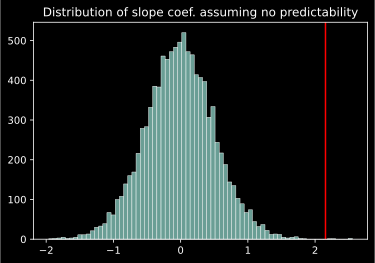

In [30]:
sns.histplot(beta_sim[1])
plt.axvline(results['Beta'].iloc[0], color='red')
plt.xlabel(None)
plt.ylabel(None)
plt.title('Distribution of slope coef. assuming no predictability')
plt.show()

#### Conclusion

We see that the size of our bias is slightly negative thorugh-out the k horizons. In the plot for $k=1$ we see that only very few of the bootstrapped betas are greater than the original estimate in problem a) of 2.15. This implies that the predictive power of $\widehat{cay}$ is not driven by small-sample bias. 

The main reason why the small sample bias is less severe for $\widehat{cay}$ compared to price-scaled variables such as the price-dividend ratio or the CAPE ratio is that the return innovations and innovations in $\widehat{cay}$ have a low degree of correlation - this would not be the case for CAPE and the return innovations.